# Disability at six months (completion)

In this notebook, we explore the completion of disability at six months

## Context about measurement of disability

Disability is measured using the modified Rankin Scale (mRS). The scale ranges from 0 to 6, where 0 is perfect health without symptoms and 6 is death. The dataset contains information on:
* Disability before the stroke
* Disability at discharge
* Disability at six months

## Aims

* Investigate the completion of disability at six months

## Purpose of this analysis

In other analyses, we are using discharge disability. One reason for that is because six month disability is so incomplete. This analysis looks into levels of completion and whether there are factors associated with completion (as we anticipate that it will not be missing at random).

## Summary

* Of patients who were alive at discharge, **35.4%** have disability at 6 months
* Completion of disability at 6 months varies substantially between stroke teams from **10.25% to 99.95%** of patients missing data
* Using descriptive analysis (and note that some of these are very marginal differences), we see **more missing data** for patients:
    * With more severe strokes or with no stroke symptoms
    * With greater discharge disability
    * Who were not thrombolysed
    * Who did not have an infarction
    * With greater prior disability
    * With younger or older age (least missing around apx. people in their 70s)
* Regression (with random undersampling to account for class imbalance) has very low accuracy

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, confusion_matrix)

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Completion of data on disability at six months

**Remove patients dead at discharge**

Data on disability at six months will not be available for patients who were dead (mRS score of 6) at discharge. Therefore, we will remove them from the analysis, and focus only on patients who were alive at discharge.

Of all the patients in the SSNAP dataset:
* 13.9% were dead at discharge
* 85.4% had a disability score of 0 to 5
* 0.7% were missing data on disability at discharge

In [4]:
# Find proportion of patients with each discharge disability score
display(data_full['discharge_disability']
        .value_counts(dropna=False, normalize=True)
        .rename_axis('Discharge Disability')
        .sort_index()
        .reset_index(name='Proportion'))

,Discharge Disability,Proportion
0,0.0,0.129267
1,1.0,0.211068
2,2.0,0.181825
3,3.0,0.160238
4,4.0,0.115781
5,5.0,0.055937
6,6.0,0.138836
7,NaN,0.007047


In [5]:
# Remove patients who were dead at discharge
data_full_alive = data_full[data_full['death'] == 0].copy()

# Print count of remaining patients
print(f'Patients not dead at discharge: {len(data_full_alive.index)}')

Patients not dead at discharge: 309046


**Find proportion missing disability at discharge and/or six months**

Of all the patients in the SSNAP dataset who were not dead at discharge:
* 35.4% have data on disability at discharge and 6 months
* 63.8% are just missing disability at 6 months
* 0.8% are missing disability at discharge and 6 months

In [6]:
(data_full_alive[['discharge_disability', 'disability_6_month']]
 .isnull()
 .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'}))
 .value_counts(normalize=True)
 .reset_index(name='proportion')
 .sort_values(by='disability_6_month', ascending=False))

,discharge_disability,disability_6_month,proportion
1,Not missing,Not missing,0.353737
0,Not missing,Missing,0.638119
2,Missing,Missing,0.008144


**Visualise completion of disability at 6 months by team**

The graph presents the proportion of patients who were not dead at discharge and are missing disability at six months. We can see there is **large variability** between teams, from 10.25% missing data to 99.95% missing data. 

count    119.000000
mean       0.641830
std        0.214977
min        0.102513
25%        0.486390
50%        0.635166
75%        0.802901
max        0.999516
Name: missing_6_month, dtype: float64

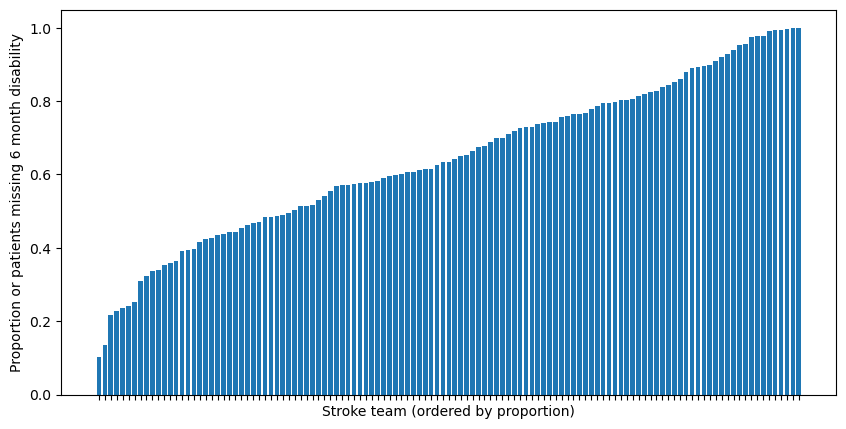

In [7]:
# Create columns where they are TRUE if missing disability
data_full_alive['missing_6_month'] = (
    data_full_alive['disability_6_month'].isnull())

# Find proportion missing disability
missing_6_month = (
    data_full_alive
    .groupby('stroke_team')['missing_6_month']
    .mean()
    .sort_values())

# Describe
display(missing_6_month.describe())

# Plot completion rate for 6 month disability in each team, ascending
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=missing_6_month.index,
       height=missing_6_month)
ax.set_xlabel('Stroke team (ordered by proportion)')
ax.set_ylabel('Proportion or patients missing 6 month disability')
ax.tick_params(labelbottom=False)
plt.show()

**Investigate whether completion is associated with size**

There appears to be no relationship between completion rate and the total patients who were alive at discharge.

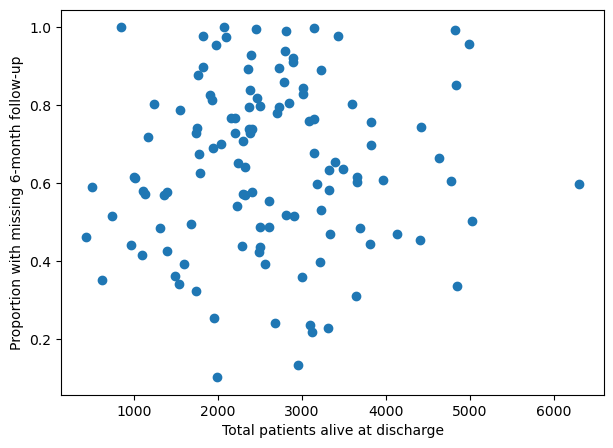

In [8]:
# Combine size with the proportion missing
team_size = (
    data_full_alive.groupby('stroke_team').size().rename('alive_at_discharge'))
team_followup_size = pd.concat([missing_6_month,
                                team_size], axis=1).reset_index()

# Find correlation
team_followup_size['alive_at_discharge'].corr(
    team_followup_size['missing_6_month'])

# Create scatter plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x=team_followup_size['alive_at_discharge'],
           y=team_followup_size['missing_6_month'])
ax.set_xlabel('Total patients alive at discharge')
ax.set_ylabel('Proportion with missing 6-month follow-up')
plt.show()

## Factors associated with completion

As above, this analysis only focusses on patients who were not marked as having died at discharge, else it would be an unfair comparison, as patients who died at discharge could not possibly have a six month follow up.

stroke_severity_groups
0        0.668312
1-4      0.639312
5-15     0.643820
16-20    0.662404
21-42    0.677691
Name: missing_6_month, dtype: float64

discharge_disability
0.0    0.654337
1.0    0.631467
2.0    0.623058
3.0    0.636253
4.0    0.668945
5.0    0.696239
Name: missing_6_month, dtype: float64

thrombolysis
0    0.647322
1    0.638126
Name: missing_6_month, dtype: float64

infarction
0.0    0.653785
1.0    0.645511
Name: missing_6_month, dtype: float64

prior_disability
0    0.641965
1    0.625371
2    0.647275
3    0.672922
4    0.698523
5    0.702144
Name: missing_6_month, dtype: float64

age
37.5    0.717289
42.5    0.693690
47.5    0.694955
52.5    0.679575
57.5    0.658418
62.5    0.647985
67.5    0.636270
72.5    0.626529
77.5    0.623241
82.5    0.630371
87.5    0.655567
92.5    0.673107
Name: missing_6_month, dtype: float64

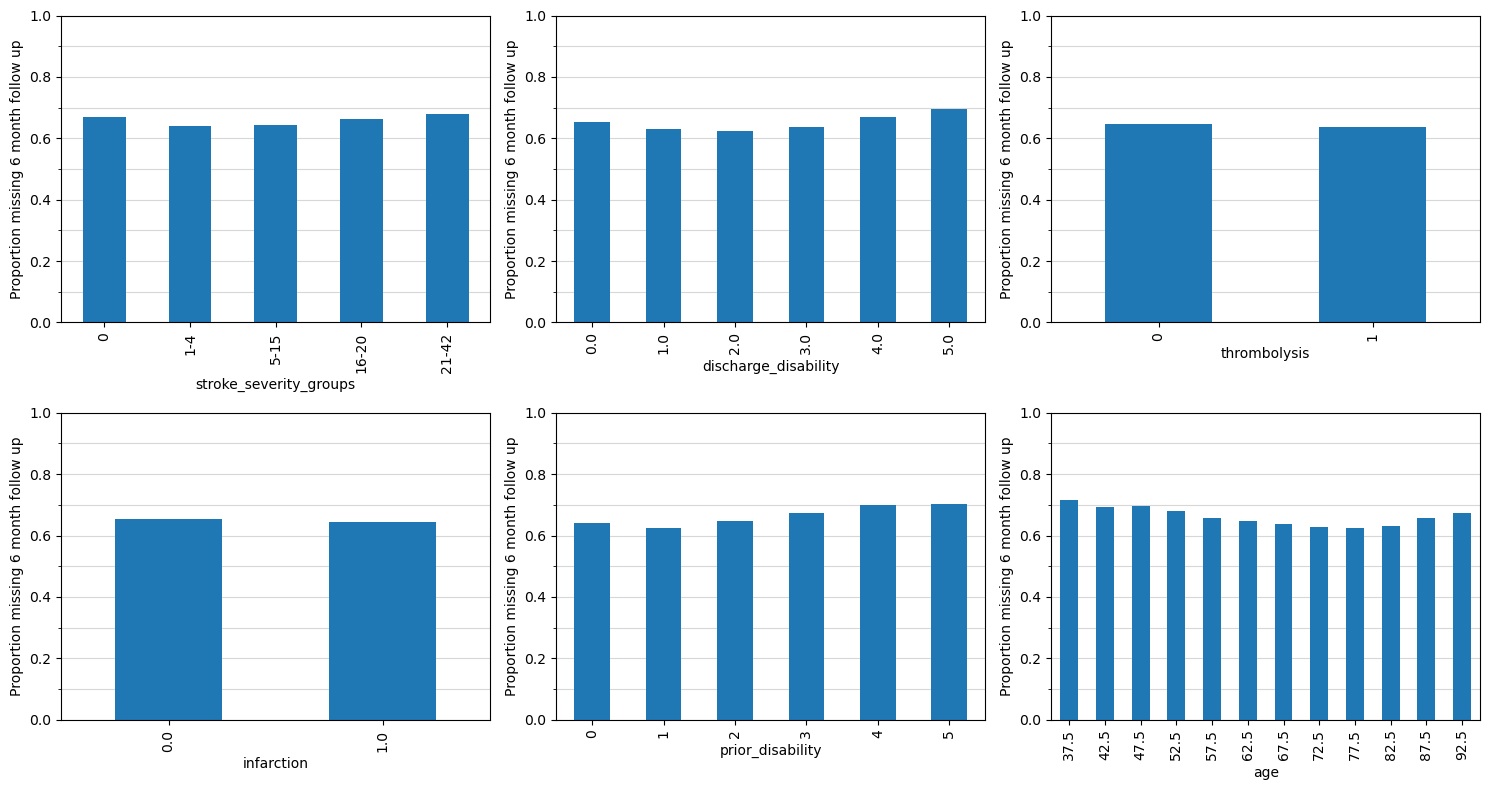

In [9]:
def plot_proportion_missing_by_variable(variable, ax, order=False):
    '''
    Creates plot of the proportion missing six month disability data
    When grouped by the specified variable.
    Inputs:
    variable - string
    ax - axis to plot on
    order - array defining order for x axis (default False)
    '''
    # Group, find proportion, display table, and plot
    df = (data_full_alive
          .groupby(variable)['missing_6_month']
          .mean())
    if order:
        display(df.loc[order])
        df.loc[order].plot(kind='bar', ax=ax)
    else:
        display(df)
        df.plot(kind='bar', ax=ax)
    ax.set_ylabel('Proportion missing 6 month follow up')

    # Set consistent y axis with horizontal grid lines
    ax.set_ylim([0, 1])
    ax.set_yticks(np.arange(0, 1, 0.1), minor=True)
    ax.grid(axis='y', which='minor', alpha=0.5)
    ax.grid(axis='y', which='major', alpha=0.5)
    ax.set_axisbelow(True)


# Set up figure
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Create stroke severity column with groups so can plot in same way as others
conditions = [(data_full_alive['stroke_severity'] == 0),
              (data_full_alive['stroke_severity'].isin(np.arange(1, 5))),
              (data_full_alive['stroke_severity'].isin(np.arange(5, 16))),
              (data_full_alive['stroke_severity'].isin(np.arange(16, 21))),
              (data_full_alive['stroke_severity'].isin(np.arange(21, 43)))]
nihss_choices = ['0', '1-4', '5-15', '16-20', '21-42']
data_full_alive['stroke_severity_groups'] = np.select(conditions,
                                                      nihss_choices)
plot_proportion_missing_by_variable('stroke_severity_groups',
                                    ax[0, 0], order=nihss_choices)

# Plot proportion missing by group
plot_proportion_missing_by_variable('discharge_disability', ax[0, 1])
plot_proportion_missing_by_variable('thrombolysis', ax[0, 2])
plot_proportion_missing_by_variable('infarction', ax[1, 0])
plot_proportion_missing_by_variable('prior_disability', ax[1, 1])
plot_proportion_missing_by_variable('age', ax[1, 2])

plt.tight_layout()
plt.show()

Observations: 
* **Stroke severity:** A slightly higher proportion of people with severe strokes are not followed up (NIHSS 21-42, 67.8%), then no symptoms (NIHSS 0, 66.8%) and moderate to severe strokes (NIHSS 16-20, 66.2%), with the least missing follow-up for moderate strokes (NIHSS 5-15, 64.4%) and mild strokes (NIHSS 1-4, 63.9%).
* **Discharge disability:** A slightly higher proportion of people with a greater discharge disability are missing follow-up (69.6%), with least missing for discharge disability of mRS 1 to 3 (but more again missing for mRS 0).
* **Thrombolysis:** A slightly lower proportion of thrombolysed patients are missing follow up (63.8%), compared with patients not thrombolysed (64.7%)
* **Infarction:** A slightly lower proportion of patients who had an infarction are missing follow up (64.6%), compared with patients who did not have an infarction (65.4%)
* **Prior disability:** A slightly higher proportion of people with a greater prior disability are missing follow up (eg. 70.2% of people who were mRS 5, compared with 64.2% mRS 0 and 62.5% mRS 1)
* **Age:** A higher proportion of people in the younger or older age categories are not followed up, with the least missing follow up in the  77.5 (i.e. 75 to 80 years old, 62.3% missing follow up)

                    count      mean       std  min  25%  50%  75%   max
missing_6_month                                                        
False            109321.0  5.370002  5.683979  0.0  2.0  3.0  7.0  42.0
True             199725.0  5.511238  5.949742  0.0  2.0  3.0  7.0  42.0


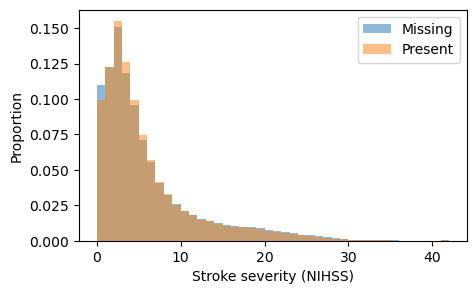

In [10]:
# For stroke severity, compare distributions using overlaid histograms
# As number of patients at higher stroke severities is very small in
# each group, so doing proportion per group would be misleading
# (unless you created larger categories combining groups)

fig, ax = plt.subplots(figsize=(5, 3))

# Seperate out
plot_missing = data_full_alive.loc[
    data_full_alive['missing_6_month'], 'stroke_severity']
plot_present = data_full_alive.loc[
    ~data_full_alive['missing_6_month'], 'stroke_severity']

# Plot overlapping histograms
ax.hist(plot_missing,
        weights=np.ones(len(plot_missing)) / len(plot_missing),
        bins=np.arange(0, 43, 1), alpha=0.5, label="Missing")
ax.hist(plot_present,
        weights=np.ones(len(plot_present)) / len(plot_present),
        bins=np.arange(0, 43, 1), alpha=0.5, label="Present")
ax.set_xlabel('Stroke severity (NIHSS)')
ax.set_ylabel('Proportion')
ax.legend()

# Describe results for each group
print(
    data_full_alive.groupby('missing_6_month')['stroke_severity'].describe())

Observations: The stroke severity of followed-up patients is, on average, slightly higher (5.51 vs 5.37). 

## Multiple logistic regression

### Dataset

The dataset is patients who have complete data data for discharge disability, stroke severity, age and whether thrombolysed. They can have incomplete data for 6-month follow-up (as that is what we are predicting).

In [11]:
# Extract relevant columns, resetting index else set on slice
reg_df = data_full[[
    'prior_disability', 'stroke_severity', 'age',
    'thrombolysis', 'discharge_disability']].reset_index(drop=True)

# Create column of whether had follow-up
reg_df['6_month_complete'] = (
    data_full['disability_6_month'].isnull().map({False: 1, True: 0}))

# Drop NA
reg_df = reg_df.dropna().reset_index(drop=True)
display(reg_df.shape)

# Count values in each
display(reg_df['6_month_complete'].value_counts(normalize=True))

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['6_month_complete']

(356355, 6)

0    0.693224
1    0.306776
Name: 6_month_complete, dtype: float64

### Regression

In [12]:
def standardise_data(X_train, X_test):
    '''
    Put features on a similar scale through standardisation.
    Just transforms features (not response/target variable).
    Invovles subtracting mean and dividing by standard deviation (SD)
    of each feature, so data have mean of 0 and SD of 1.
    Test data is standardised on training data mean and SD.
    '''

    # Set up scaling object and fit on training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Apply scaling to training and test data
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

In [13]:
def logistic_regression(df, standardise):
    '''
    Run logistic regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns feature weights, accuracy and confusion matrix
    Inputs:
    df - dataframe containing variables used in regression
    standardise - true or false, whether want to standardise variables
    '''
    # Define predictor and response variables
    X = df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
    y = df['6_month_complete']

    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Get accuracy
        reg_results['accuracy'] = model.score(X_test, y_test)

        # Get confusion matrix
        predictions = model.predict(X_test)
        reg_results['confusion'] = confusion_matrix(y_test, predictions)

    return (reg_results)

In [14]:
logistic_regression(reg_df, standardise=True)

defaultdict(list,
            {'feature_weights': [array([[ 0.04656685, -0.13427037,  0.07747488,  0.04044917, -0.46130055]]),
              array([[ 0.04511475, -0.1328435 ,  0.07879367,  0.03787641, -0.45563004]]),
              array([[ 0.04239823, -0.13610947,  0.07885667,  0.04281216, -0.45526751]]),
              array([[ 0.04392537, -0.13297785,  0.07556136,  0.03773259, -0.45832226]]),
              array([[ 0.0408941 , -0.13453528,  0.07800657,  0.04224722, -0.45412759]])],
             'accuracy': 0.6920486593425096,
             'confusion': array([[49307,     8],
                    [21940,    16]])})

Predicts everything to not be a follow-up as that is the majority in the dataset. Would need to perform undersampling to balance the dataset.

### Random undersampling

Very simple method of undersampling - randomly removing points from the majority class until it has the same number of points as the majority class.

In [15]:
# Seperate into minority and majority
minority = reg_df[reg_df['6_month_complete'] == 1]
majority = reg_df[reg_df['6_month_complete'] == 0]

# Randomly undersample majority class to be size of minority
majority_under = majority.sample(minority.shape[0])

# Combine together again
reg_df_under = pd.concat([majority_under, minority]).reset_index()

# Demonstrate counts
reg_df_under['6_month_complete'].value_counts()

0    109321
1    109321
Name: 6_month_complete, dtype: int64

In [16]:
logistic_regression(reg_df_under, standardise=True)

defaultdict(list,
            {'feature_weights': [array([[ 0.04703205, -0.12254233,  0.07573366,  0.03339329, -0.46743752]]),
              array([[ 0.054982  , -0.12387545,  0.07085426,  0.03905425, -0.47335221]]),
              array([[ 0.05334856, -0.12321454,  0.08037915,  0.04038137, -0.47323735]]),
              array([[ 0.04877762, -0.12038816,  0.07621313,  0.04049618, -0.46952761]]),
              array([[ 0.05267271, -0.12486921,  0.07459176,  0.03982176, -0.47283985]])],
             'accuracy': 0.5684001097694841,
             'confusion': array([[10945, 10903],
                    [ 7970, 13910]])})

Very low accuracy - 0.57.

Would need to test assumptions - but anticipating it does not satisfy them all.